In [365]:
import numpy
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/alg010/repos/coda/codes/')
import CodaPCA
sys.path.insert(1, '/home/alg010/repos/RM-tools/')
from RMutils import util_RM

import cmocean
import sklearn.svm

import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2910633053993473517
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14623199379186576750
physical_device_desc: "device: XLA_CPU device"
]


In [336]:
import importlib
import generate_spectra
importlib.reload(generate_spectra)
importlib.reload(sklearn.svm)

<module 'sklearn.svm' from '/home/alger/miniconda3/lib/python3.6/site-packages/sklearn/svm/__init__.py'>

In [337]:
# freqs = numpy.loadtxt('freqs_cosmology_22.txt')
# Matches Brown+18.
band12 = numpy.linspace(700, 1300, 600) * 1e6  # Hz
band3 = numpy.linspace(1500, 1800, 300) * 1e6  # Hz
freqs = numpy.concatenate((band12, band3))

In [338]:
spectra = generate_spectra.generate_spectra(
    freqs, util_RM, n_spectra=100000, phi_sampling=500, max_noise=0.333,
    min_phi=-100, max_phi=100, phi_padding=50)

100%|██████████| 100000/100000 [00:37<00:00, 2671.43it/s]


In [339]:
test_spectra = generate_spectra.generate_spectra(
    freqs, util_RM, n_spectra=30000, phi_sampling=500, max_noise=0.333,
    min_phi=-100, max_phi=100, phi_padding=50)

100%|██████████| 30000/30000 [00:12<00:00, 2470.00it/s]


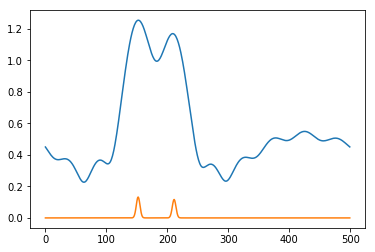

In [340]:
# plt.plot()
%matplotlib inline
plt.plot(abs(spectra['sim_fdf'][2]))
plt.plot(abs(spectra['targets'][2]))

In [598]:
pca = CodaPCA.CodaPCA(4, 0.005, [20, 20], alg=CodaPCA.Alg.CODAAE)

In [599]:
features = abs(spectra['sim_fdf'])
features.shape

(100000, 500)

In [600]:
tf = pca.fit_transform(features, epochs=20)

[epoch     0] L=406.3580


In [601]:
tf

array([[ 0.681137  , -1.6995822 ,  1.291591  , -0.12310456],
       [ 1.5545591 ,  1.436753  , -0.49809718,  1.0917226 ],
       [-1.7652051 ,  1.5542947 , -0.97185147,  0.16206516],
       ...,
       [ 1.0475153 ,  2.1394558 ,  0.5096435 ,  1.0956693 ],
       [-1.233035  ,  1.3718432 ,  1.6677482 ,  0.01943459],
       [ 1.6955429 , -0.8018286 , -0.64275014,  1.0022248 ]],
      dtype=float32)

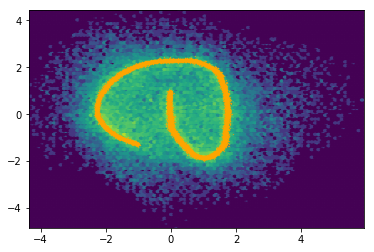

In [602]:
%matplotlib inline
plt.subplot(1, 1, 1)
plt.hexbin(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1], bins='log')
plt.scatter(tf[spectra['simple'], 0], tf[spectra['simple'], 1], s=0.1, c='orange')


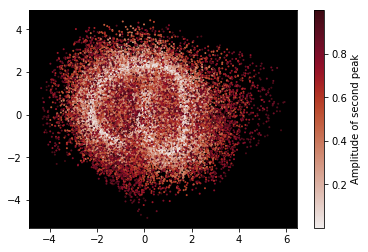

In [603]:
%matplotlib inline
ax = plt.subplot(1, 1, 1, facecolor='black')
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=spectra['amps'][~spectra['simple'], 1],
            cmap=cmocean.cm.amp, s=1)
cb = plt.colorbar()
cb.set_label('Amplitude of second peak')

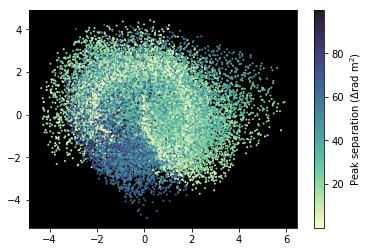

In [604]:
ax = plt.subplot(1, 1, 1, facecolor='black')
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=separations[~spectra['simple']],
            cmap=cmocean.cm.deep, s=1)
cb = plt.colorbar()
cb.set_label('Peak separation ($\\Delta$rad m$^2$)')

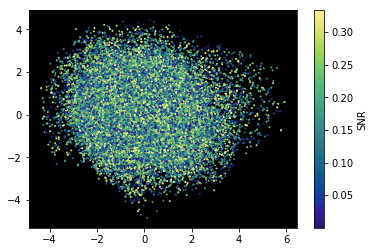

In [605]:
ax = plt.subplot(1, 1, 1, facecolor='black')
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=spectra['noise'][~spectra['simple'], 0],
            cmap=cmocean.cm.haline, s=1)
cb = plt.colorbar()
cb.set_label('SNR')

In [606]:
import sklearn.linear_model, sklearn.pipeline, sklearn.preprocessing
# svm = sklearn.svm.OneClassSVM(kernel='rbf', gamma=3, max_iter=1000)
clf = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
#                                  ('svc', sklearn.svm.SVC(probability=True, gamma=3, max_iter=10000)),
                                 ('svm', sklearn.svm.OneClassSVM(kernel='rbf', gamma=20, max_iter=10000)),
    ])
clf.fit(tf[spectra['simple']][:10000])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=20, kernel='rbf',
      max_iter=10000, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False))])

In [609]:
# X, Y, Z = numpy.mgrid[-5:5.0:0.2, -4:4:0.2, -5:5:0.5]
# XYZ = numpy.stack([X.ravel(), Y.ravel(), Z.ravel()]).T
# scores = clf.decision_function(XYZ)

In [610]:
# plt.pcolormesh(X[:, :, 0], Y[:, :, 0], scores.reshape(X.shape).mean(axis=-1))
# # plt.scatter(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1], s=10)
# # plt.scatter(tf[spectra['simple'], 0], tf[spectra['simple'], 1], s=10, color='black')
# # plt.legend(['complex', 'simple'])

In [611]:
predictions = clf.decision_function(tf)#[:, 1]

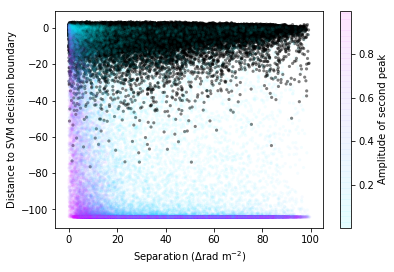

In [614]:
%matplotlib inline
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
amps = spectra['amps'][:, 1]
plt.scatter(separations[spectra['simple']], predictions[spectra['simple']],
            s=10, alpha=0.5, edgecolor='None',
            c='black')
plt.scatter(separations[~spectra['simple']], predictions[~spectra['simple']],
            s=10, alpha=0.05, edgecolor='None',
            c=amps[~spectra['simple']],
            cmap='cool')
plt.xlabel('Separation ($\\Delta$rad m$^{-2}$)')
plt.ylabel('Distance to SVM decision boundary')
cb = plt.colorbar()
cb.set_label('Amplitude of second peak')

Text(0.5,0,'Threshold')

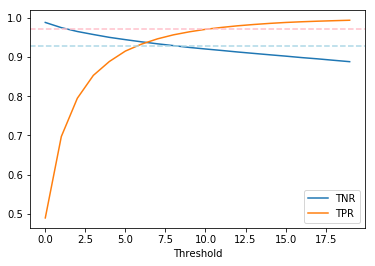

In [613]:
import sklearn.metrics, scipy.special

thresholds = numpy.linspace(0, -30, 20)
cms = []
for t in thresholds:
    predicted_labels = predictions > t
    cm = sklearn.metrics.confusion_matrix(spectra['simple'], predicted_labels).astype(float)
    cm /= cm.sum(axis=1, keepdims=True)
    cms.append(cm.diagonal().ravel())

plt.plot(cms)
    
cm_brown = numpy.array([[46538, 3618],
                        [1481, 48318]]).astype(float)
cm_brown /= cm_brown.sum(axis=1, keepdims=True)

plt.axhline(cm_brown[0, 0], c='lightblue', linestyle='--')
plt.axhline(cm_brown[1, 1], c='pink', linestyle='--')
plt.legend(['TNR', 'TPR'])

plt.xlabel('Threshold')

In [588]:
real_spectra = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/all_spectra.npy')

In [615]:
real_labels = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/pixel_labels.npy')

In [616]:
real_spectra_mag = abs(real_spectra)
real_spectra_mag_ = real_spectra_mag / real_spectra_mag.max(axis=1, keepdims=True)
real_spectra_mag_.dtype

dtype('float32')

In [641]:
tf_real_simtrained = pca.transform(real_spectra_mag_)

In [642]:
spectra.keys()

dict_keys(['depths', 'amps', 'simple', 'spectra', 'spectra_noisy', 'fdf_gt', 'sim_fdf', 'targets', 'noise'])

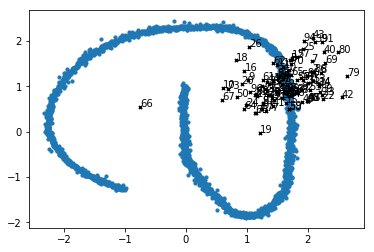

In [644]:
%matplotlib inline
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tf[spectra['simple'], 0][::10],
           tf[spectra['simple'], 1][::10], s=10)

for i in range(100):
    mask = real_labels == i
    avg = tf_real_simtrained[mask].mean(axis=0)
    plt.scatter(avg[0], avg[1], s=10, c='k', marker='x')
    plt.text(avg[0], avg[1], i)
plt.show()

In [ ]:
pca_real = CodaPCA.CodaPCA(2, 1e-3, [10, 10], alg=CodaPCA.Alg.CODAAE)

In [ ]:
tf_real = pca_real.fit_transform(real_spectra_mag, epochs=100)

In [ ]:
plt.hexbin(tf_real[:, 0], tf_real[:, 1], bins='log')

In [ ]:
tf_sim_realtrained = pca_real.transform(features)

In [ ]:
plt.scatter(tf_sim_realtrained[~spectra['simple'], 0], tf_sim_realtrained[~spectra['simple'], 1], s=10)
plt.scatter(tf_sim_realtrained[spectra['simple'], 0], tf_sim_realtrained[spectra['simple'], 1], s=10)
plt.legend(['complex', 'simple'])